# mnist 호출

In [ ]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# Optimizer

In [ ]:
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# Layer

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 중간 데이터（backward 시 사용）
        self.x = None
        self.col = None
        self.col_W = None

        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

  # coding: utf-8


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.

    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

# 새 섹션

In [ ]:
class SimpleConvNet:
    """
    다음과 같은 CNN을 구성한다.
    → Conv → ReLU → Pooling → Affine → ReLU → Affine → Softmax →
    전체 구현은 simple_convnet.py 참고
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,
                             'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        # 초기화 인수로 주어진 하이퍼파라미터를 딕셔너리에서 꺼내고 출력 크기를 계산한다.
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / \
            filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) *
                               (conv_output_size/2))

        # 1층의 합성곱 계층과 2, 3층의 완전연결 계층의 가중치와 편향 생성
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층을 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        """추론을 수행"""
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """손실함수 값 계산"""
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        """오차역전파법으로 기울기를 구함"""
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

In [ ]:
class Trainer2:

    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose:
                print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [ ]:
import pickle
import matplotlib.pyplot as plt

network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=15, output_size=10, weight_init_std=0.01)

max_epochs = 20
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 실험

In [ ]:
class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='adam', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)

        self.current_iter += 1

        # 테스트 정확도를 매번 확인하여 99% 이상일 경우 학습 중단
        x_test_sample, t_test_sample = self.x_test, self.t_test
        if self.evaluate_sample_num_per_epoch is not None:
            t = self.evaluate_sample_num_per_epoch
            x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

        test_acc = self.network.accuracy(x_test_sample, t_test_sample)
        if test_acc >= 0.99:
            if self.verbose:
                print(f"=== Iteration:{self.current_iter}, train loss:{loss}, test acc:{test_acc} ===")
                print(f"=== Test accuracy reached 99%. Stopping training. ===")
            return True  # 학습 중단 신호 반환

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            if self.evaluate_sample_num_per_epoch is not None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose:
                print(f"=== epoch:{self.current_epoch}, train loss:{loss}, train acc:{train_acc}, test acc:{test_acc} ===")

        return False  # 학습 계속 진행

    def train(self):
        for i in range(self.max_iter):
            if self.train_step():
                break  # 학습 중단 신호가 반환되면 루프 탈출

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


In [ ]:

network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=15, output_size=10, weight_init_std=0.01)

max_epochs = 20
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()


=== epoch:1, train loss:0.21909241790206851, train acc:0.925, test acc:0.924 ===
=== epoch:2, train loss:0.13883125817998163, train acc:0.958, test acc:0.955 ===
=== epoch:3, train loss:0.08770771203092015, train acc:0.965, test acc:0.961 ===
=== epoch:4, train loss:0.06966998995862105, train acc:0.975, test acc:0.97 ===
=== epoch:5, train loss:0.079466962129633, train acc:0.977, test acc:0.973 ===
=== epoch:6, train loss:0.11081197156387568, train acc:0.981, test acc:0.971 ===
=== epoch:7, train loss:0.025746444152759777, train acc:0.982, test acc:0.978 ===
=== epoch:8, train loss:0.020832298142524547, train acc:0.985, test acc:0.984 ===
=== epoch:9, train loss:0.034014540137346505, train acc:0.985, test acc:0.984 ===
=== epoch:10, train loss:0.02184144270202796, train acc:0.983, test acc:0.98 ===
=== epoch:11, train loss:0.008452193716953861, train acc:0.988, test acc:0.986 ===
=== epoch:12, train loss:0.09338544881257961, train acc:0.991, test acc:0.981 ===


KeyboardInterrupt: 

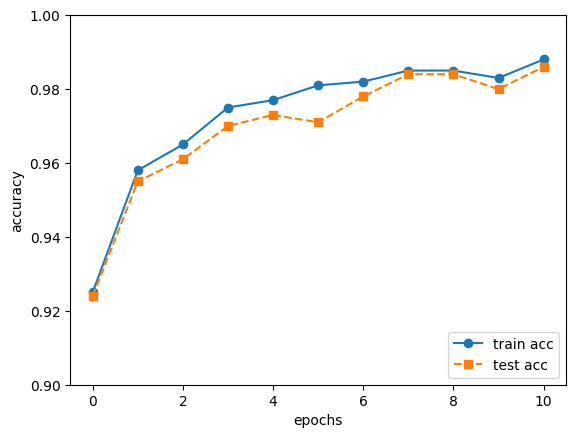

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 결과에서 train_acc와 test_acc 추출
train_acc_list = [0.925, 0.958, 0.965, 0.975, 0.977, 0.981, 0.982, 0.985, 0.985, 0.983, 0.988]
test_acc_list = [0.924, 0.955, 0.961, 0.97, 0.973, 0.971, 0.978, 0.984, 0.984, 0.98, 0.986]

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='s')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')
plt.show()